# CIFAR vectorized LiRA example

This notebook mirrors A_cifar_main.ipynb but configures the LiRA attack to use the vectorized fast path.

It is safer to delete previous results for target and shadow models as it will train new models. 


In [1]:
import os
import sys
import yaml

project_root = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
sys.path.insert(0, project_root)


In [2]:
target_dir = "./robust/target/signals"
shadow_dir = "./robust/output/signals"


Next, we create the population dataset by concatenating the train and test data. To create the population, we make use of the UserDataset provided in the InputHandler.

## Reusing cached logits
If you already have saved or cached target model logits, shadow models logits along with the shadow models in_mask, you can directly call the lira_vectorized or lira_iterative function and calculate the lira score. The following cell shows a simple example that imports the saved data or generates random example data if no saved data is detected.

In [3]:
from leakpro.attacks.mia_attacks.lira import lira_vectorized, lira_iterative
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# Paths to the logits and in_mask
shadow_path = Path(shadow_dir + "/rescaled_logits.npy")
inmask_path = Path(shadow_dir + "/in_indices_masks.npy")
target_path = Path(target_dir + "/rescaled_logits.npy")
target_inmask_path = Path(target_dir + "/in_indices_masks.npy")

if shadow_path.exists() and inmask_path.exists() and target_path.exists():
    print("Loading cached logits and membership mask...")
    shadow_logits = np.load(shadow_path)
    shadow_inmask = np.load(inmask_path).astype(bool)
    target_logits = np.load(target_path)
else:   ### thid is for smoke test only, just a toy example 
    print("Cached files not found; generating synthetic logits for a smoke test.")
    rng = np.random.default_rng(2345)
    N, M = 256, 32  # number of audit samples (N) and shadow models (M)
    shadow_logits = rng.normal(size=(N, M))
    target_logits = rng.normal(size=N)
    shadow_inmask = rng.random((N, M)) < 0.5
    

Loading cached logits and membership mask...


In [4]:
%%time
scores_vectorized = lira_vectorized(target_logits=target_logits[:,0], 
                         shadow_logits=shadow_logits,
                         shadow_inmask=shadow_inmask,
                         var_calculation="carlini",
                         online=True,
                         fix_var_threshold=32)

CPU times: user 22 ms, sys: 67 μs, total: 22.1 ms
Wall time: 20.5 ms


In [5]:
%%time
scores_iterative = lira_iterative(target_logits=target_logits[:,0], 
                         shadow_logits=shadow_logits,
                         shadow_inmask=shadow_inmask,
                         var_calculation="carlini",
                         online=True,
                         fix_var_threshold=32)

Processing audit samples: 100%|██████████| 60000/60000 [00:10<00:00, 5752.23it/s]

CPU times: user 10.7 s, sys: 1.52 s, total: 12.2 s
Wall time: 10.4 s


Computed LiRA scores for 60000 samples.
First five vectorized scores: [ 2.01212927  2.65843147  0.50774865 -6.41733766  0.63906874]
Computed LiRA scores for 60000 samples.
First five iterative scores: [ 2.01212927  2.65843147  0.50774865 -6.41733766  0.63906874]


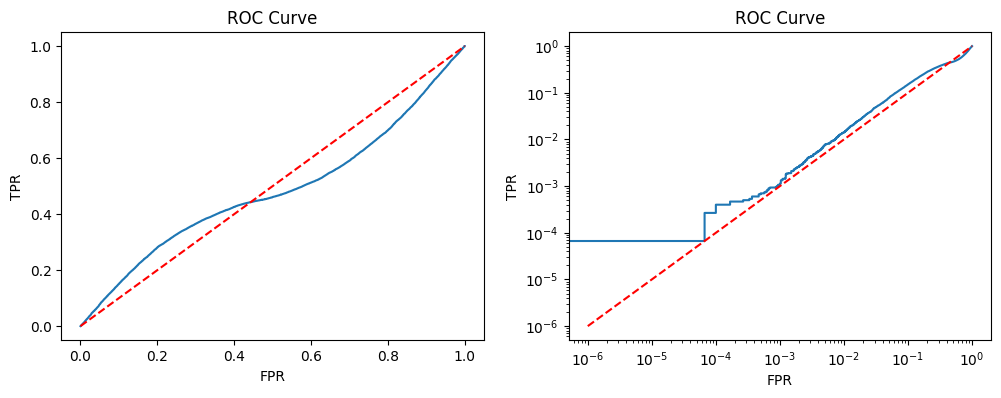

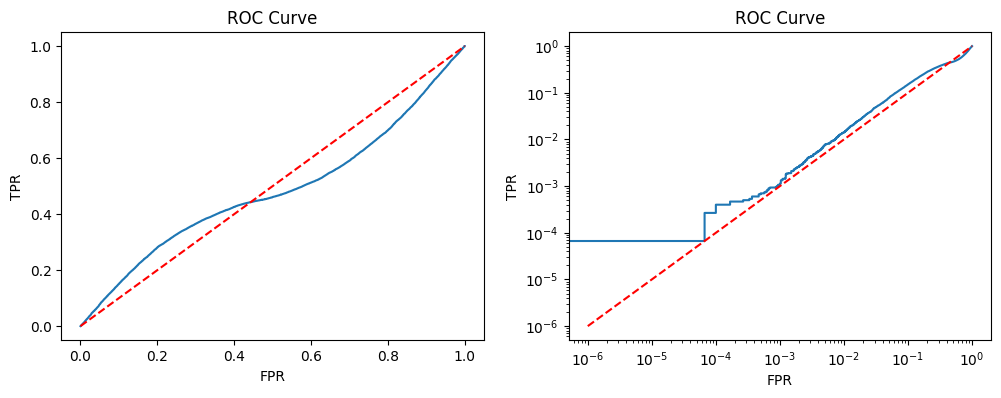

In [6]:
print(f'Computed LiRA scores for {scores_vectorized.shape[0]} samples.')
print('First five vectorized scores:', scores_vectorized[:5])

print(f'Computed LiRA scores for {scores_iterative.shape[0]} samples.')
print('First five iterative scores:', scores_iterative[:5])

# Load or synthesize membership labels for ROC computation
if target_inmask_path.exists():
    membership = np.load(target_inmask_path).astype(bool)
else:
    rng = np.random.default_rng(123)
    membership = rng.random(scores_vectorized.shape[0]) < 0.5

def plot_results(results, labels=None, smarts=None):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    for ax, flag in zip(axs, [True, False]):
        for i, (fpr, tpr) in enumerate(results):
            label = None if labels is None else labels[i]
            smart = '-' if smarts is None else smarts[i]
            if flag:
                ax.plot(fpr, tpr, smart, label=label)
            else:
                ax.loglog(fpr, tpr, smart, label=label)
        if results:
            diag = np.linspace(1e-6 if not flag else 0.0, 1.0, 200)
            ax.plot(diag, diag, 'r--', label='random')
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.set_title('ROC Curve')
    plt.show()

from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(membership.astype(int), scores_vectorized)
plot_results([(fpr, tpr)], labels=['Vectorized LiRA (cached)'])

fpr, tpr, _ = roc_curve(membership.astype(int), scores_iterative)
plot_results([(fpr, tpr)], labels=['Iterative LiRA (cached)'])